In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import math
import pyfinancialdata
import trade_functions

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, Activation

Using TensorFlow backend.


## Model and settings

In [2]:
units = 25
epoch = 20
model_name = 'LSTM'

# Train on last 500 prices and try to predict the next price
look_back = 500
time_ahead = 1

# Create the model
model = Sequential()
model.add(LSTM(units, input_shape=(1, look_back)))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(optimizer='adam', loss='mean_squared_error')

## Train and test data: GBP USD exchange rate, 2006-2017

In [3]:
train_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

test_data = pyfinancialdata.get_multi_year(
    provider='oanda',
    instrument='GBP_USD',
    years=[2015, 2016, 2017],
    time_group='12h',
    price_calculation='close',
    drop_non_price_columns=True,
)

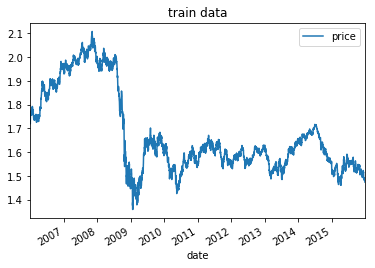

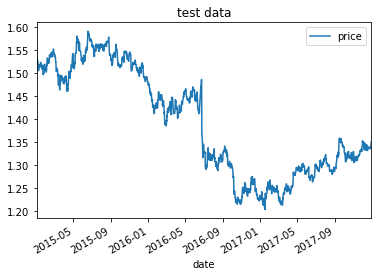

In [4]:
train_data.plot(title='train data')
test_data.plot(title='test data')

In [5]:
def create_training_dataset(dataset, look_back, time_ahead):
    '''
    Converts an array of values into a dataset matrix of X and Y for a sequential model
    '''
    dataX, dataY = [], []

    for i in range(len(dataset) - look_back - time_ahead + 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back + time_ahead - 1, 0])

    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    dataY = np.array(dataY)

    return dataX, dataY

In [6]:
# Create dataset from the DataFrame and normalise
dataset = train_data['price'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# Create X, Y for training
trainX, trainY = create_training_dataset(dataset, look_back=look_back, time_ahead=time_ahead)

## Train the model

In [7]:
model.fit(trainX, trainY, epochs=epoch, batch_size=1, verbose=0)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [7]:
# Uncomment this to load the saved model
# model = load_model('trained_model.h5')



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Test the model

In [8]:
# Create a scaler and fit
test_scaler = MinMaxScaler(feature_range=(0, 1))
test_scaler.fit(test_data['price'].values.reshape(-1, 1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [9]:
# a function to predict
def predict(values):
    values = test_scaler.transform(values.reshape(-1, 1))
    values = np.reshape(values, (1, 1, look_back))
    prediction = model.predict(values)
    prediction = prediction.reshape(-1, 1)
    return test_scaler.inverse_transform(prediction)

In [10]:
# Put predictions from model into the dataframe with the test prices
test_data['prediction_next'] = test_data['price'].rolling(window=look_back).apply(predict, raw=True)
test_data['prediction'] = test_data['prediction_next'].shift(time_ahead)
test_data.dropna(subset=['prediction_next'], inplace=True)

In [11]:
# RMSE
rmse = np.sqrt(
    mean_squared_error(
        y_true=test_data.dropna()['price'].values,
        y_pred=test_data.dropna()['prediction'].values
    )
)
print('RMSE: {0}'.format(rmse))

RMSE: 0.030233574533641783


In [12]:
# add columns for price direction and predicted direction
test_data['next_direction'] = np.where(test_data['price'] > test_data['price'].shift(-1), -1, 1)
test_data['next_direction_prediction'] = np.where(test_data['prediction_next'] > test_data['price'], 1, -1)
test_data['correct'] = test_data['next_direction_prediction'] == test_data['next_direction']

## Results

In [13]:
# How often does the model predict the correct price change direction
test_data['correct'].value_counts()

True     630
False    580
Name: correct, dtype: int64

In [14]:
# Create a column for the position we should take
test_data['position'] = test_data['prediction_next']

In [15]:
trades = trade_functions.create_trades_from_positions(test_data.copy())

1113 positions to plot...


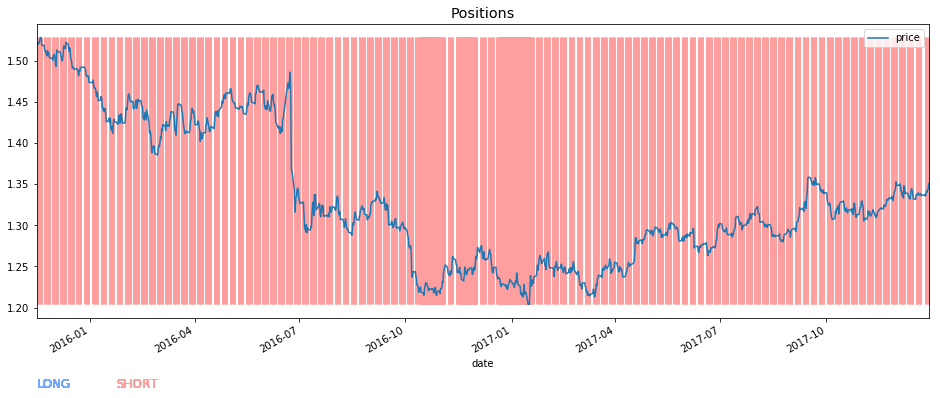

In [16]:
trade_functions.show_positions_on_price_plot(test_data.copy())

In [17]:
trade_functions.get_trade_statistics(trades.copy())

Profitable: 50.09%
Ratio of long to short positions: 0
Median profit: 0.0
Total profit: -0.26
Median position length: 1.0
Number of trades: 1112
